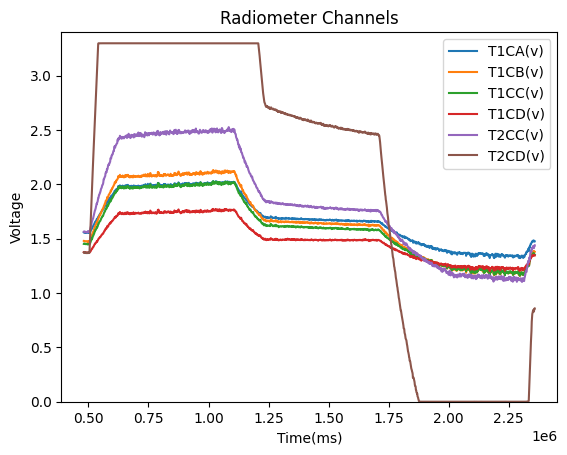

In [193]:
#imports
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from scipy.optimize import curve_fit
import scipy.signal

# -------------ADJUST FOR YOUR PROCEDURE------------------#
file_name = 'radiometer_25_10-60_070723_sensor'
sensor_file = 'Data/' + file_name + '.csv'

offset = 60000 * 8 #value should be 60000 * minutes for how long the sensor was on before sweep
high_temp = 60
low_temp = 10
interval = -25
temp_ranges = np.arange(high_temp, low_temp - abs(interval), interval) #range and interval of temperature steps
time_interval = 10 #minute length that each temperature is held

time_interval_ms = 60000 * time_interval #convert minutes to milliseconds
begin_cutoff = 60000 * 2 #60000 * number of minutes to cut off from beginning of each temp
end_cutoff = 60000 * 1.5 #60000 * number of minutes to cut off from ending of each temp

# -------------UNCOMMENT FOR PLOTTING BB TEMP------------------#
#bb_file = 'Data/radiometer1_30_5-55_061623_BB.txt'

# bb_df = pd.read_csv(bb_file) #read blackbody temperatures from text file
#bb_df.to_csv(r'Data/radiometer1_30_5-55_061623_BB.csv', index = None)

#bb_df.columns = ['BB Temp']
#display(bb_df)
# -------------UNCOMMENT FOR PLOTTING BB TEMP------------------#

data = pd.read_csv(sensor_file)
if not os.path.exists('Reports/' + file_name):
     os.mkdir('Reports/' + file_name)
     
channel_col = []
internal_col = []
nums = [1,2]
channels = ['A', 'B', 'C', 'D']
for num in nums:
     for chan in channels:
          channel_col.append("T" + str(num) + "C" + str(chan) + "(v)")
     internal_col.append("T" + str(num) +"Therm(c)")

# -------------UNCOMMENT FOR ROLLING WINDOW------------------#
""" window_size = 25 
#window = scipy.signal.gaussian(M=30, std=6)
#smoothed = np.convolve(data[channel_col], window, mode='valid')
data_rolling = data[channel_col].rolling(window_size).mean()
#data_rolling = smoothed

data_rolling.insert(loc = 0,
     column = "Time(ms)",
     value = data["Time(ms)"])
data_rolling.drop(data_rolling.index[:window_size], inplace=True)
display(data_rolling)
plt.figure()
data_rolling.plot(x = "Time(ms)", y = channel_col)
data = data_rolling """

# -------------UNCOMMENT FOR ROLLING WINDOW------------------#     

channel_col.remove("T2CA(v)") #used to remove clipping channel
channel_col.remove("T2CB(v)") #used to remove clipping channel
#data[(data["Time(ms)"] > (offset + time_interval_ms * 4)) & (data["Time(ms)"] < (offset + time_interval_ms * 7))].plot(x = "Time(ms)", y = channel_col)
data[data["Time(ms)"] > (offset)].plot(x = "Time(ms)", y = channel_col)

plt.title("Radiometer Channels")
plt.ylim([0, 3.4])
plt.ylabel("Voltage")
plt.savefig('Reports/' + file_name + '/raw_data_' + file_name + '.png', bbox_inches='tight')
plt.show()



Segment the data into different BB temps

In [194]:
#segment the data into the different BB temps
temp_dict = {}
lower_bound = offset #time after s

#create dictionary of dataframes, cutoff 5 minutes from begininng and half a minute from the end to obtain stabilized temp
for i in range(0, temp_ranges.size): 
    temp_dict[str(temp_ranges[i])] = data[(data["Time(ms)"] > (lower_bound+begin_cutoff)) & (data["Time(ms)"] < (lower_bound + time_interval_ms-end_cutoff))]
    lower_bound += time_interval_ms

Plot the sensor readings at different blackbody temperatures

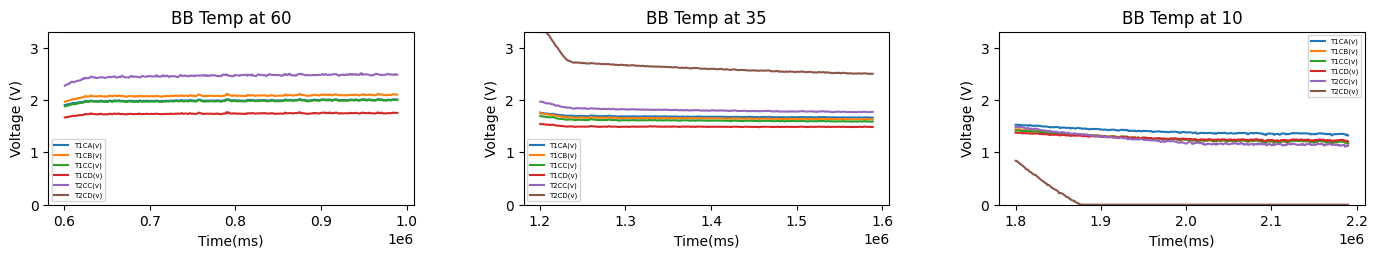

,Time(ms),T1CA(v),T1CB(v),T1CC(v),T1CD(v),T1Therm(c),T2CA(v),T2CB(v),T2CC(v),T2CD(v),T2Therm(c)
Max at 60,989109.0,2.020319,2.121341,2.017716,1.768930,4.153768,1.685452,1.688385,2.513264,3.297412,3.861832
VPP60,388580.0,0.116843,0.152925,0.138610,0.102360,0.355739,1.016912,0.113232,0.239389,0.000013,0.364896
Max at 35,1588878.0,1.759310,1.753982,1.697770,1.544833,4.719480,1.621496,1.606530,1.967929,3.297156,4.429197
VPP35,388549.0,0.098736,0.127057,0.112931,0.064128,0.337826,0.069911,0.032364,0.202229,0.798330,0.338066
Max at 10,2189808.0,1.527020,1.442242,1.420643,1.376721,4.904690,1.271342,1.604184,1.491985,0.839005,4.612988
VPP10,389702.0,0.205585,0.279999,0.259536,0.176380,0.071925,1.270625,1.599017,0.386537,0.838874,0.071204


In [195]:
temp_max_min = pd.DataFrame()
temp_plots = plt.figure().tight_layout()
i = 1

#specific_temp_dict = ['35', '30', '25']
for key in temp_dict:
    ax = plt.subplot(3, 4, i)
    plt.subplots_adjust(left=0.1, right=2.9, bottom=0.1, top=1.9, wspace=0.3, hspace=1)
    #plt.suptitle('Voltage at Each BB Temp')
    plt.plot(temp_dict[key].loc[:,"Time(ms)"], temp_dict[key].loc[:,channel_col])
    plt.title("BB Temp at " + key)
    plt.ylabel("Voltage (V)")
    plt.ylim([0, 3.3])
    plt.xlabel("Time(ms)")
    plt.legend(channel_col, fontsize = 5)
    i += 1
    max_temp = temp_dict[key].max() #get max temps
    max_temp_df = pd.DataFrame({'Max at ' + str(key): max_temp}).T

    min_temp = temp_dict[key].min() #get min temps 
    min_temp_df = pd.DataFrame({'Min at ' + str(key): min_temp}).T

    vpp = max_temp - min_temp #calculate peak-to-peak
    vpp_df = pd.DataFrame({'VPP' + str(key): vpp}).T
    temp_max_min= pd.concat([temp_max_min, max_temp_df, vpp_df]) #transpose

plt.savefig('Reports/' + file_name + '/segmented_temp_voltages_' + file_name + '.png', bbox_inches='tight')
plt.show()
display(temp_max_min) #plot segmented temp data

In [196]:
#create histograms for each channel
""" for key in temp_dict:
    plt.figure()
    temp = temp_dict[key]
    i = 1
    for chan in channel_col:
        plt.subplot(2, 4, i)
        plt.hist(temp[chan], bins=30, density=True, alpha=0.6, color='g')
        plt.title(chan)
        i += 1 """

" for key in temp_dict:\n    plt.figure()\n    temp = temp_dict[key]\n    i = 1\n    for chan in channel_col:\n        plt.subplot(2, 4, i)\n        plt.hist(temp[chan], bins=30, density=True, alpha=0.6, color='g')\n        plt.title(chan)\n        i += 1 "

In [197]:
#calculate averages, std devs and rms values
ch_avgs = pd.DataFrame()
ch_std_dev = pd.DataFrame()
ch_rms = pd.DataFrame()
for key in temp_dict:
    temps = temp_dict[key]
    ch_avgs[key] = temps[channel_col].mean()
    ch_std_dev[key] = temps[channel_col].std()
    ch_rms[key]  = np.sqrt((temps[channel_col] ** 2).mean())
ch_avgs=ch_avgs.T
ch_avgs.insert(loc = 0,
          column = 'Temp',
          value = temp_ranges)
ch_std_dev =ch_std_dev.T
ch_std_dev.insert(loc = 0,
          column = 'Temp',
          value = temp_ranges)

ch_rms =ch_rms.T
ch_rms.insert(loc = 0,
          column = 'Temp',
          value = temp_ranges)

# -------------UNCOMMENT FOR PLOT OF AVERAGE VOLTAGE VS. BB TEMP------------------#
""" plt.plot(ch_avgs.loc[:,"Temp"], ch_avgs.loc[:,channel_col], marker = '.')
plt.legend(channel_col, fontsize = 5)
plt.xlabel("Temp (\N{DEGREE CELSIUS})")
plt.ylabel("Average Voltage (V)")
plt.title("Avg. Voltage vs. Blackbody Temperature")
plt.savefig('Reports/' + file_name + '/' + 'avg_voltage_' + file_name + '.png', bbox_inches='tight') """
# -------------UNCOMMENT FOR PLOT OF AVERAGE VOLTAGE VS. BB TEMP------------------#

#display(ch_avgs) #display statistics
display(ch_std_dev)

#display(ch_rms)

ch_avgs.to_csv('Reports/' + file_name + '/voltage_avg_' + file_name + '.csv')
ch_std_dev.to_csv('Reports/' + file_name + '/voltage_std_dev_' + file_name + '.csv')
#ch_rms.to_csv('Reports/' + file_name + '/voltage_std_dev.csv')

,Temp,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CC(v),T2CD(v)
60,60,0.016925,0.021305,0.019586,0.014597,0.035931,0.000003
35,35,0.016877,0.020893,0.019115,0.009780,0.038405,0.157582
10,10,0.052808,0.071625,0.064935,0.043083,0.102811,0.193110


In [198]:
#Planck Radiance
def planck_radiance(wavelength, temperature):
    h = 6.62607015e-34  # Planck's constant
    c = 299792458  # Speed of light
    k = 1.38064852e-23  # Boltzmann constant

    #convert celsius to Kelvin
    temperature += 273.15
    
    numerator = 2 * h * c ** 2
    denominator = wavelength ** 5 * (np.exp((h * c) / (wavelength * k * temperature)) - 1)
    radiance = numerator / denominator
    return radiance

def linear_fit(x, slope , b):
    return slope * x + b

def quadratic_fit(x, a, b, c):
    return a * (x ** 2) + b * x + c

def gaussian_fit(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

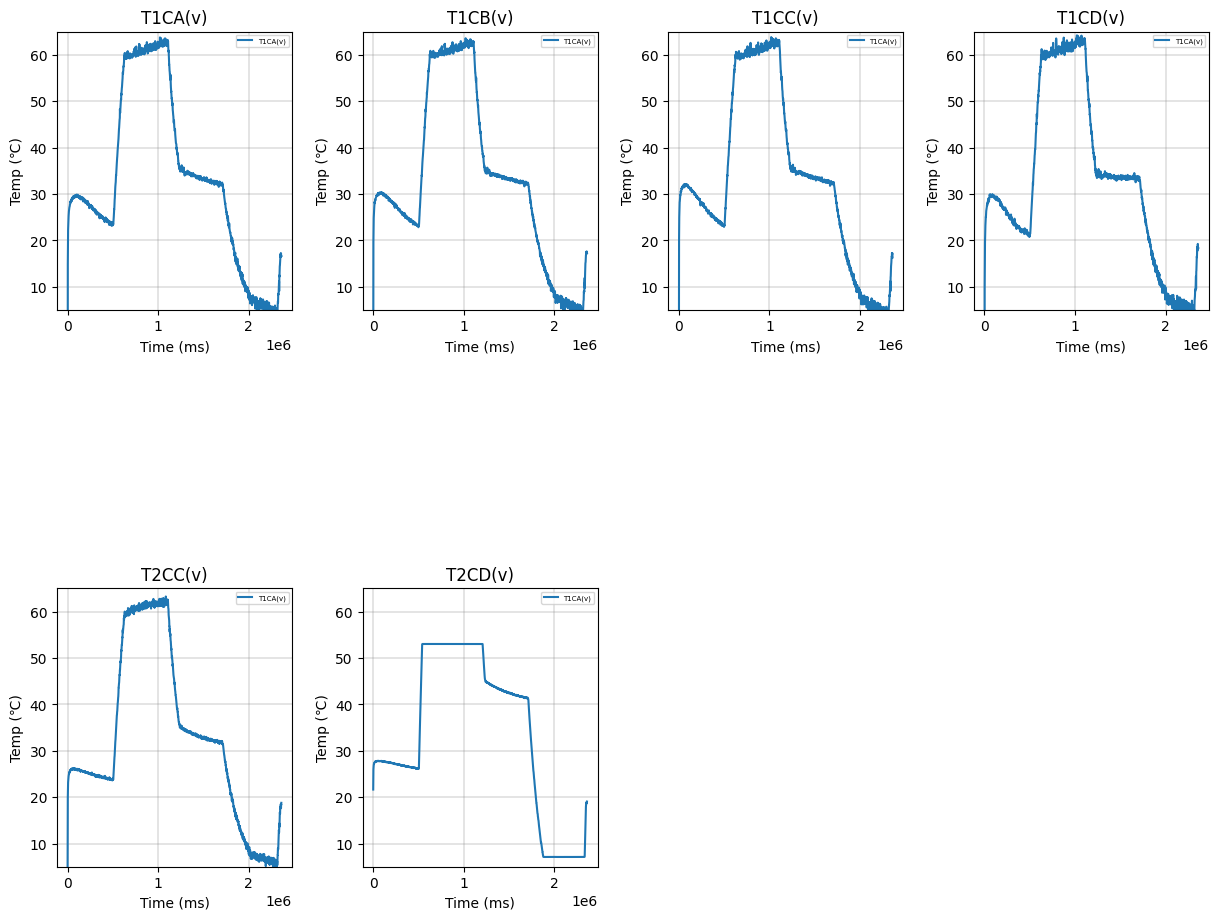

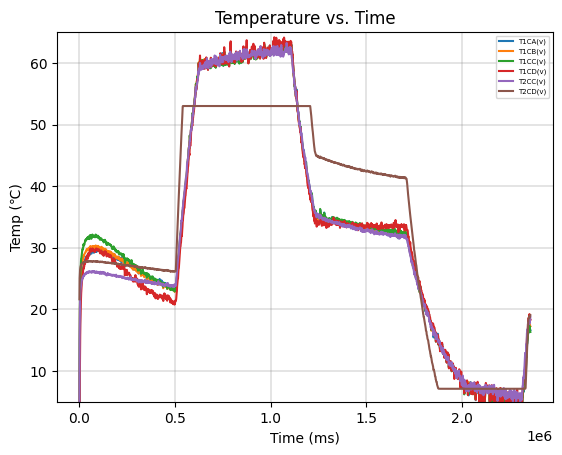

' #Plot error\nplt.figure()\nlower_bound = offset\n#display(data_temp)\nfor i in range(0, bb_df[\'BB Temp\'].size):\n    bb_temp = bb_df[\'BB Temp\']\n    data_temp_interval = data_temp[(data_temp["Time(ms)"] > (lower_bound)) & (data_temp["Time(ms)"] < (lower_bound + time_interval_ms))]\n    #display(data_temp_interval)\n    temp_error = pd.concat([temp_error, ((abs((data_temp_interval[channel_col] - bb_temp[i])/bb_temp[i])) * 100)]) #convert the voltage to a temp and calculate percent error\n    lower_bound += time_interval_ms\ntemp_times = data_temp[(data_temp["Time(ms)"] > (1200000)) & (data_temp["Time(ms)"] < (lower_bound))]["Time(ms)"]\ntemp_error.insert(loc = 0,column = \'Time(ms)\', value = temp_times)\n\nfor ch in channel_col:\n    plt.plot(temp_error["Time(ms)"], temp_error[ch])\n\nplt.xlabel("Time (ms)")\nplt.ylabel("Percent Error (%)")\nplt.title("Temperature Percent Error vs. Time")\nplt.grid(color=\'gray\', linestyle=\'-\', linewidth=0.3)\nplt.legend(channel_col, fontsize 

In [199]:
#obtain curves for data
temp_popt = {}
temp_pcov = {}

#fig, ax = plt.subplots(figsize = (10, 5))
bb_index = np.arange(1.2e6,8.4e6,0.6e6)
data_temp = data.copy()
temp_error = pd.DataFrame()
i = 1
for chan in channel_col:
    #apply linear fit for each channel
    temp_popt[chan], temp_pcov[chan] = curve_fit(linear_fit, ch_avgs[chan], ch_avgs["Temp"])
    calc_temp = linear_fit(data[chan], *temp_popt[chan])
    data_temp[chan] = calc_temp
    ax = plt.subplot(3, 4, i)
    plt.subplots_adjust(left=0.1, right=1.9, bottom=0.1, top=3, wspace=0.3, hspace=1)
    #plt.plot(data["Time(ms)"], calc_temp)
    plt.plot(data_temp.loc[:,"Time(ms)"], data_temp[chan])
    plt.xlabel("Time (ms)")
    plt.ylabel("Temp (\N{DEGREE CELSIUS})")
    plt.title(chan)
    plt.grid(color='gray', linestyle='-', linewidth=0.3)
    plt.legend(channel_col, fontsize = 5)
    plt.ylim((temp_ranges.min() - 5,temp_ranges.max() + 5))
    i += 1

plt.savefig('Reports/' + file_name + '/' + 'indiv_channel_temps_' + file_name + '.png', bbox_inches='tight')
plt.show()

plt.figure()
for chan in channel_col:
    plt.plot(data["Time(ms)"], data_temp[chan])
    plt.xlabel("Time (ms)")
    plt.ylabel("Temp (\N{DEGREE CELSIUS})")
    plt.title("Temperature vs. Time")
    plt.grid(color='gray', linestyle='-', linewidth=0.3)
    plt.legend(channel_col, fontsize = 5)
    plt.ylim((temp_ranges.min() - 5,temp_ranges.max() + 5))
    #plt.scatter(bb_index, bb_df['BB Temp'])
    
plt.savefig('Reports/' + file_name + '/' + 'temps_' + file_name + '.png', bbox_inches='tight')
plt.show()
# -------------UNCOMMENT FOR ERROR CALC, REQUIRES BB TEMPS------------------#
""" #Plot error
plt.figure()
lower_bound = offset
#display(data_temp)
for i in range(0, bb_df['BB Temp'].size):
    bb_temp = bb_df['BB Temp']
    data_temp_interval = data_temp[(data_temp["Time(ms)"] > (lower_bound)) & (data_temp["Time(ms)"] < (lower_bound + time_interval_ms))]
    #display(data_temp_interval)
    temp_error = pd.concat([temp_error, ((abs((data_temp_interval[channel_col] - bb_temp[i])/bb_temp[i])) * 100)]) #convert the voltage to a temp and calculate percent error
    lower_bound += time_interval_ms
temp_times = data_temp[(data_temp["Time(ms)"] > (1200000)) & (data_temp["Time(ms)"] < (lower_bound))]["Time(ms)"]
temp_error.insert(loc = 0,column = 'Time(ms)', value = temp_times)

for ch in channel_col:
    plt.plot(temp_error["Time(ms)"], temp_error[ch])

plt.xlabel("Time (ms)")
plt.ylabel("Percent Error (%)")
plt.title("Temperature Percent Error vs. Time")
plt.grid(color='gray', linestyle='-', linewidth=0.3)
plt.legend(channel_col, fontsize = 5)
plt.scatter(bb_index, bb_df['BB Temp'])
display(temp_error)
plt.plot(data["Time(ms)"], linear_fit(data["T2CD(v)"], *temp_popt["T2CD(v)"]))
plt.plot(data["T1CB(v)"], linear_fit(data["T1CB(v)"], *temp_popt["T1CB(v)"])) """
# -------------UNCOMMENT FOR ERROR CALC, REQUIRES BB TEMPS------------------#


,Temp,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CC(v),T2CD(v)
60,60,1.439666,1.311394,1.377027,1.562477,1.469799,0.000037
35,35,1.435584,1.286075,1.343874,1.046874,1.571026,2.193755
10,10,4.492019,4.408828,4.565326,4.611813,4.205665,2.688368


' for ch in channel_col:\n    plt.scatter(temp_ranges, conv_ch_avgs[ch])\nplt.xlabel("BB Temp. (℃)")\nplt.ylabel("Average Recorded Temp. (℃)")\nplt.title("Avg. Temp. vs. BB Temp")\nplt.legend(channel_col, fontsize = 5)\nplt.savefig(\'Reports/\' + file_name + \'/\' + \'avg_temps_\' + file_name + \'.png\', bbox_inches=\'tight\') '

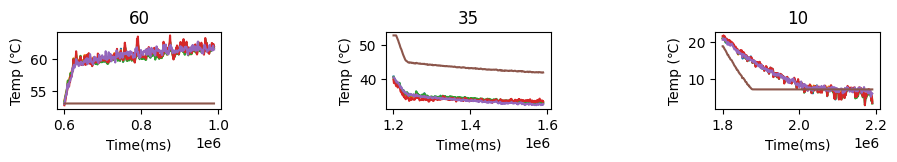

In [200]:
#calculate noise in temperature domain
conv_temp_dict = {}
avg_conv_temp_dict = {}
plt.figure()

conv_t_df = pd.DataFrame()
conv_ch_avgs = pd.DataFrame()
conv_ch_std_dev = pd.DataFrame()

lower_bound = offset
#for each segmented temp data, convert voltage to temps and calculate mean/standard deviation
for i in range(0, temp_ranges.size):
    conv_temp_dict[str(temp_ranges[i])] = data_temp[(data_temp["Time(ms)"] > (lower_bound+begin_cutoff)) & (data_temp["Time(ms)"] < (lower_bound + time_interval_ms-end_cutoff))]
    lower_bound += time_interval_ms

i = 1
#for each BB temp, find the average and standard deviation of the recorded temperature
for temp in conv_temp_dict: 
    temp_segment = conv_temp_dict[temp]
    conv_ch_avgs[temp] = temp_segment[channel_col].mean()
    conv_ch_std_dev[temp] = temp_segment[channel_col].std()
    max_temp = temp_segment.max() #get max temps

    min_temp = temp_segment.min() #get min temps 

    conv_tpp = max_temp - min_temp
    conv_tpp_df = pd.DataFrame({'TPP' + str(temp): conv_tpp}).T
    conv_t_df = pd.concat([conv_t_df, conv_tpp_df])
    ax = plt.subplot(3, 4, i)
    plt.subplots_adjust(left=0.1, right=1.9, bottom=0.1, top=0.9, wspace=1, hspace=1)

    plt.plot(temp_segment.loc[:,"Time(ms)"], temp_segment.loc[:,channel_col])
    plt.title(temp)
    plt.ylabel("Temp (\N{DEGREE CELSIUS})")
    plt.xlabel("Time(ms)")
    i += 1

#add converted temp averages and std deviations to the dataframe and plot them
conv_ch_avgs=conv_ch_avgs.T
conv_ch_avgs.insert(loc = 0, column = 'Temp', value = temp_ranges)
conv_ch_std_dev =conv_ch_std_dev.T
conv_ch_std_dev.insert(loc = 0, column = 'Temp', value = temp_ranges)
#display(conv_ch_avgs)
display(conv_ch_std_dev)
#display(conv_t_df)

conv_ch_avgs.to_csv('Reports/' + file_name + '/temp_avg_' + file_name + '.csv')
conv_ch_std_dev.to_csv('Reports/' + file_name + '/temp_std_dev_' + file_name + '.csv')
#ch_rms.to_csv('Reports/' + file_name + '/voltage_std_dev.csv')

# -------------UNCOMMENT FOR AVERAGE MEASURED TEMPS vs BB TEMPS, REQUIRES BB TEMPS------------------#
""" for ch in channel_col:
    plt.scatter(temp_ranges, conv_ch_avgs[ch])
plt.xlabel("BB Temp. (\N{DEGREE CELSIUS})")
plt.ylabel("Average Recorded Temp. (\N{DEGREE CELSIUS})")
plt.title("Avg. Temp. vs. BB Temp")
plt.legend(channel_col, fontsize = 5)
plt.savefig('Reports/' + file_name + '/' + 'avg_temps_' + file_name + '.png', bbox_inches='tight') """
# -------------UNCOMMENT FOR AVERAGE MEASURED TEMPS vs BB TEMPS, REQUIRES BB TEMPS------------------#



Calculating Temperature to Radiance Curves

,Wavelength,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CA(v),T2CB(v),T2CC(v),T2CD(v)
0,0.000008,0.000187,0.000133,0.002295,0.000338,1.000000e-07,2.800000e-07,0.000000e+00,0.000238
1,0.000008,-0.000067,-0.000430,0.001002,-0.000545,6.000000e-08,2.600000e-07,0.000000e+00,0.000238
2,0.000008,0.000286,-0.000307,-0.000578,-0.000681,8.000000e-08,4.000000e-08,0.000000e+00,0.000238
3,0.000008,0.001145,0.000409,-0.000880,-0.000311,6.000000e-08,-1.400000e-07,0.000000e+00,0.000238
4,0.000008,0.001702,0.000956,0.000748,-0.000220,-1.200000e-07,-1.800000e-07,0.000000e+00,0.000238
...,...,...,...,...,...,...,...,...,...
522,0.000014,0.000311,0.002002,0.002871,-0.003243,2.447940e-03,1.038520e-03,1.935983e-109,0.883726
523,0.000014,-0.002504,0.003802,-0.003127,-0.003970,1.114500e-03,7.430000e-04,2.387713e-112,0.714796
524,0.000014,-0.002829,0.007300,-0.003019,0.001566,1.115700e-03,1.264460e-03,2.645844e-115,0.476531
525,0.000014,-0.000525,0.009125,0.002786,0.007141,3.649520e-03,2.681280e-03,2.632938e-118,0.238265


,Temperature,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CC(v),T2CD(v)
0,60,1.673251e+07,1.675579e+07,1.674886e+07,1.668726e+07,1.297834e+07,1.461135e+07
1,35,1.104079e+07,1.117999e+07,1.125042e+07,1.131443e+07,9.693500e+06,1.049686e+07
2,10,6.776811e+06,6.953477e+06,7.052762e+06,7.172019e+06,6.893184e+06,7.138610e+06


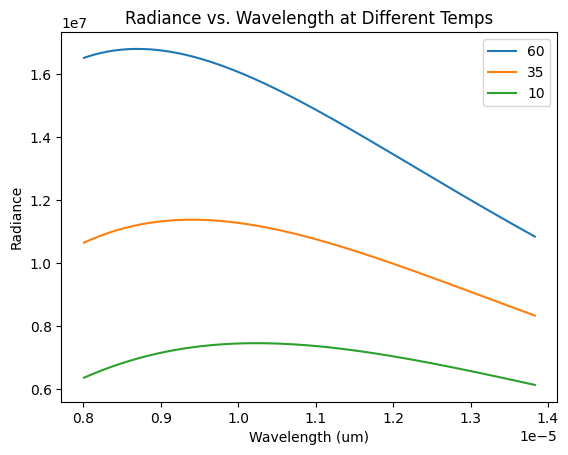

In [201]:
#units are watt/meter squared,

#read in response curve
dex = pd.read_csv("Data/dexter_filters.csv")
dex["Wavelength"] = dex["Wavelength"] * 1e-6
#normalize each channel by dividing by the max
dex_norm = dex
#chans = ['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8']
for ch in channel_col:
    dex_norm[ch] = dex[ch] / dex[ch].abs().max()

display(dex_norm)


#use Planck radiance equation to obtain curves
planck = pd.DataFrame()
planck["Wavelength"] = dex_norm["Wavelength"]
plt.figure()
for temp in temp_ranges:
    planck[temp] = planck_radiance((planck["Wavelength"]), temp)
    plt.plot(planck["Wavelength"], planck[temp])
    plt.legend(temp_ranges)
    plt.title("Radiance vs. Wavelength at Different Temps")
    plt.xlabel("Wavelength (um)")
    plt.ylabel("Radiance")

be_radiance = pd.DataFrame()
be_radiance["Temperature"] = temp_ranges

#calculate BE radiance for each temperature at each channel
for ch in channel_col:
    radiance = []
    for temp in temp_ranges:
        numerator = 0
        for a, b in zip(planck[temp], dex_norm[ch]):
            numerator += a * b
        
        denominator = dex_norm[ch].sum()
        radiance.append(numerator/denominator)
    be_radiance[ch] = radiance

display(be_radiance)



Plot radiance vs. time from data

,Time(ms),T1CA(v),T1CB(v),T1CC(v),T1CD(v),T1Therm(c),T2CA(v),T2CB(v),T2CC(v),T2CD(v),T2Therm(c)
0,769,-3764.966385,-1190.743262,-1312.996762,-5059.922012,3.552858,1.295470,1.665059,156.744876,308.200262,3.244663
1,1898,401.443243,753.639937,873.318548,-192.544901,3.553702,1.202128,1.660097,641.014940,355.959728,3.245183
2,3027,1150.932334,1140.772932,1342.588871,921.107969,3.554791,0.757824,0.635674,774.210620,368.806445,3.246394
3,4156,1466.177881,1303.419572,1562.221100,1454.731557,3.555463,0.319679,1.150109,841.381481,375.374547,3.246885
4,5285,1645.309731,1393.989503,1680.201276,1755.613972,3.555758,0.004943,1.496061,882.621394,378.997224,3.247325
...,...,...,...,...,...,...,...,...,...,...,...
2083,2353584,1327.647623,1002.671064,1113.228248,1932.415658,4.901473,0.000826,0.818483,685.386961,267.358771,4.608506
2084,2354713,1352.904003,1016.688117,1134.413845,1883.336964,4.901779,0.003511,0.800498,683.150112,266.593996,4.608226
2085,2355842,1300.264903,986.886193,1101.384157,1885.049756,4.902315,0.021092,0.808290,715.380816,271.099087,4.608172
2086,2356971,1313.882242,998.072737,1079.827144,1819.518265,4.902359,0.000918,0.805467,709.607696,270.532082,4.608592


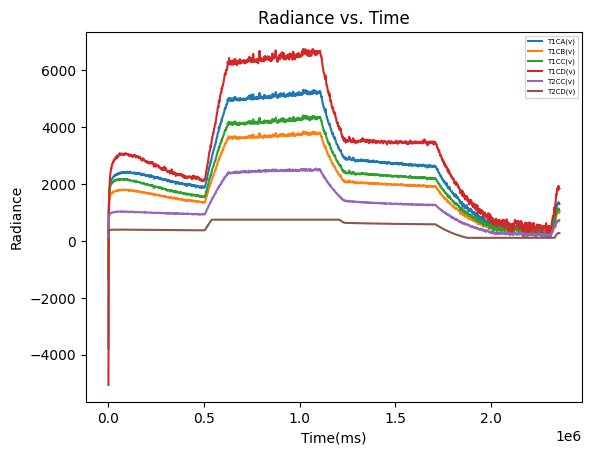

In [202]:
data_radiance = pd.DataFrame()
data_radiance = data.copy()
radiance_popt = {}
radiance_pcov = {}
plt.figure()
for chan in channel_col:
    #determine line of best fit for temperature to radiance function using lookup table, then convert temps using that line
    radiance_popt[chan], radiance_pcov[chan] = curve_fit(linear_fit, be_radiance["Temperature"], be_radiance[chan])
    temp_to_radiance = linear_fit(data_temp[chan], *temp_popt[chan] )
    data_radiance[chan] = temp_to_radiance
    plt.plot(data_temp["Time(ms)"], data_radiance[chan])
    plt.xlabel("Time(ms)")
    plt.ylabel("Radiance")
    plt.legend(channel_col, fontsize = 5)
plt.title("Radiance vs. Time")

plt.savefig('Reports/' + file_name + '/' + 'radiance_' + file_name + '.png', bbox_inches='tight')
display(data_radiance)

,Temp,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CC(v),T2CD(v)
60,60,2653.218174,1930.860515,2220.098591,3405.263414,1273.056542,580.02226
35,35,526.536942,404.375557,433.993326,704.559835,291.103279,112.80018
10,10,NaN,NaN,NaN,NaN,NaN,NaN


,Temp,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CC(v),T2CD(v)
60,60,179.136282,127.088911,150.003962,197.201038,84.101672,52.756068
35,35,234.832670,170.960066,201.847475,318.872748,111.435793,30.244595
10,10,NaN,NaN,NaN,NaN,NaN,NaN


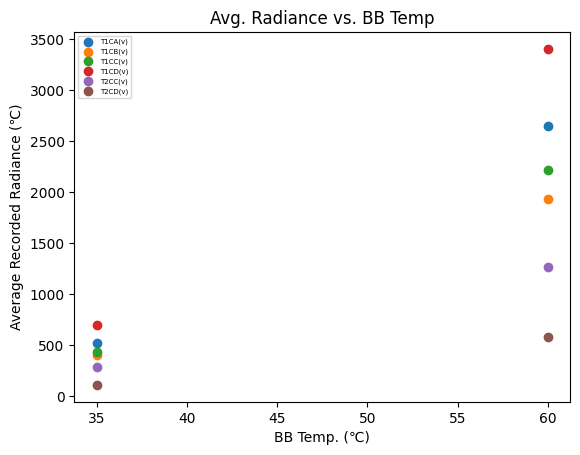

In [203]:
#calculate radiance in temperature domain (THIS PART IS WIP)
rad_dict = {}
plt.figure()

rad_ch_avgs = pd.DataFrame()
rad_ch_std_dev = pd.DataFrame()
lower_bound = 1200000
#for each segmented temp data, convert voltage to temps and calculate mean/standard deviation
for i in range(0, temp_ranges.size):
    rad_dict[str(temp_ranges[i])] = data_radiance[(data_radiance["Time(ms)"] > (lower_bound+120000)) & (data_radiance["Time(ms)"] < (lower_bound + time_interval_ms-30000))]
    lower_bound += time_interval_ms

#for each BB temp, find the average and standard deviation of the recorded temperature
for rad in rad_dict: 
    rad_segment = rad_dict[rad]
    rad_ch_avgs[rad] = rad_segment[channel_col].mean()
    rad_ch_std_dev[rad] = rad_segment[channel_col].std()
  
rad_ch_avgs=rad_ch_avgs.T
rad_ch_avgs.insert(loc = 0, column = 'Temp', value = temp_ranges)
rad_ch_std_dev =rad_ch_std_dev.T
rad_ch_std_dev.insert(loc = 0, column = 'Temp', value = temp_ranges)
display(rad_ch_avgs)
display(rad_ch_std_dev)
for ch in channel_col:
    plt.scatter(temp_ranges, rad_ch_avgs[ch])
plt.xlabel("BB Temp. (\N{DEGREE CELSIUS})")
plt.ylabel("Average Recorded Radiance (\N{DEGREE CELSIUS})")
plt.title("Avg. Radiance vs. BB Temp")
plt.legend(channel_col, fontsize = 5)